# Convergence of mappings

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from neurodyn import *
import numpy as np
import matplotlib.pyplot as plt, matplotlib.patheffects as pe

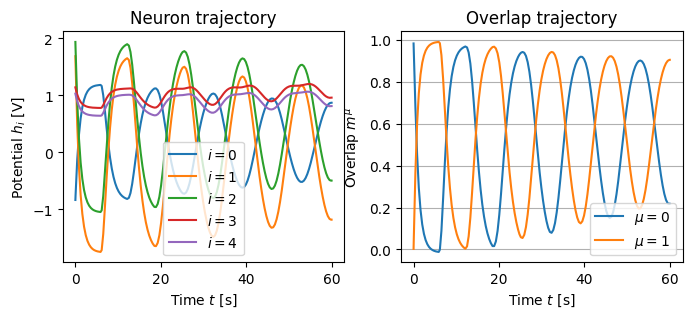

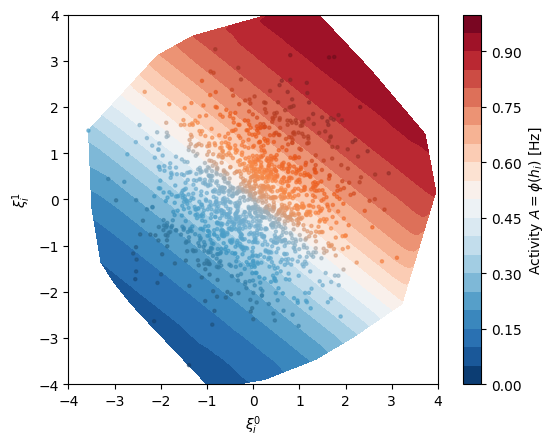

In [6]:
rnn = LowRankCyclingRNN.new_valentin(p=2, N=20_000, phi=sigmoid, I_ext=zero, exclude_self_connections=True, delta=6, shift=1)
res = rnn.simulate(rnn.F[:, 0], (0, 60), dt_max=0.4, progress=True, cache=True)

fig, axes = plt.subplots(ncols=2, figsize=(8, 3))
plot_neuron_trajectory(res, figax=(fig, axes[0]));
plot_overlap_trajectory(rnn, res, figax=(fig, axes[1]));
plt.show()

activity = rnn.phi(res.h[:, 3])
fig, ax = plt.subplots()
plot_2D_embedding_contour(rnn, activity, figax=(fig, ax))
plot_2D_embedding_scatter(rnn, activity, figax=(fig, ax))
ax.set_xlim((-4, 4))
ax.set_ylim((-4, 4))
plt.show()

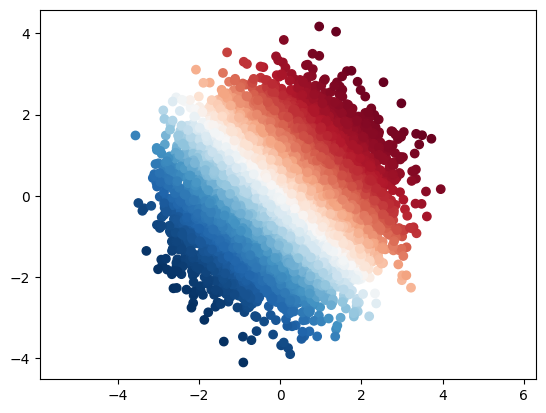

In [22]:
def fake_activity(F, n=(1,1)):
	# make up some overlap state m0=0.5, m1=0.5
	# this could be obtained from PCA
	n = np.array(n, dtype=float)
	n /= np.linalg.norm(n)
	return sigmoid(F.dot(n))

plt.scatter(*rnn.F.T, c=fake_activity(rnn.F), cmap='RdBu_r')
plt.axis('equal');

## Visualize indices

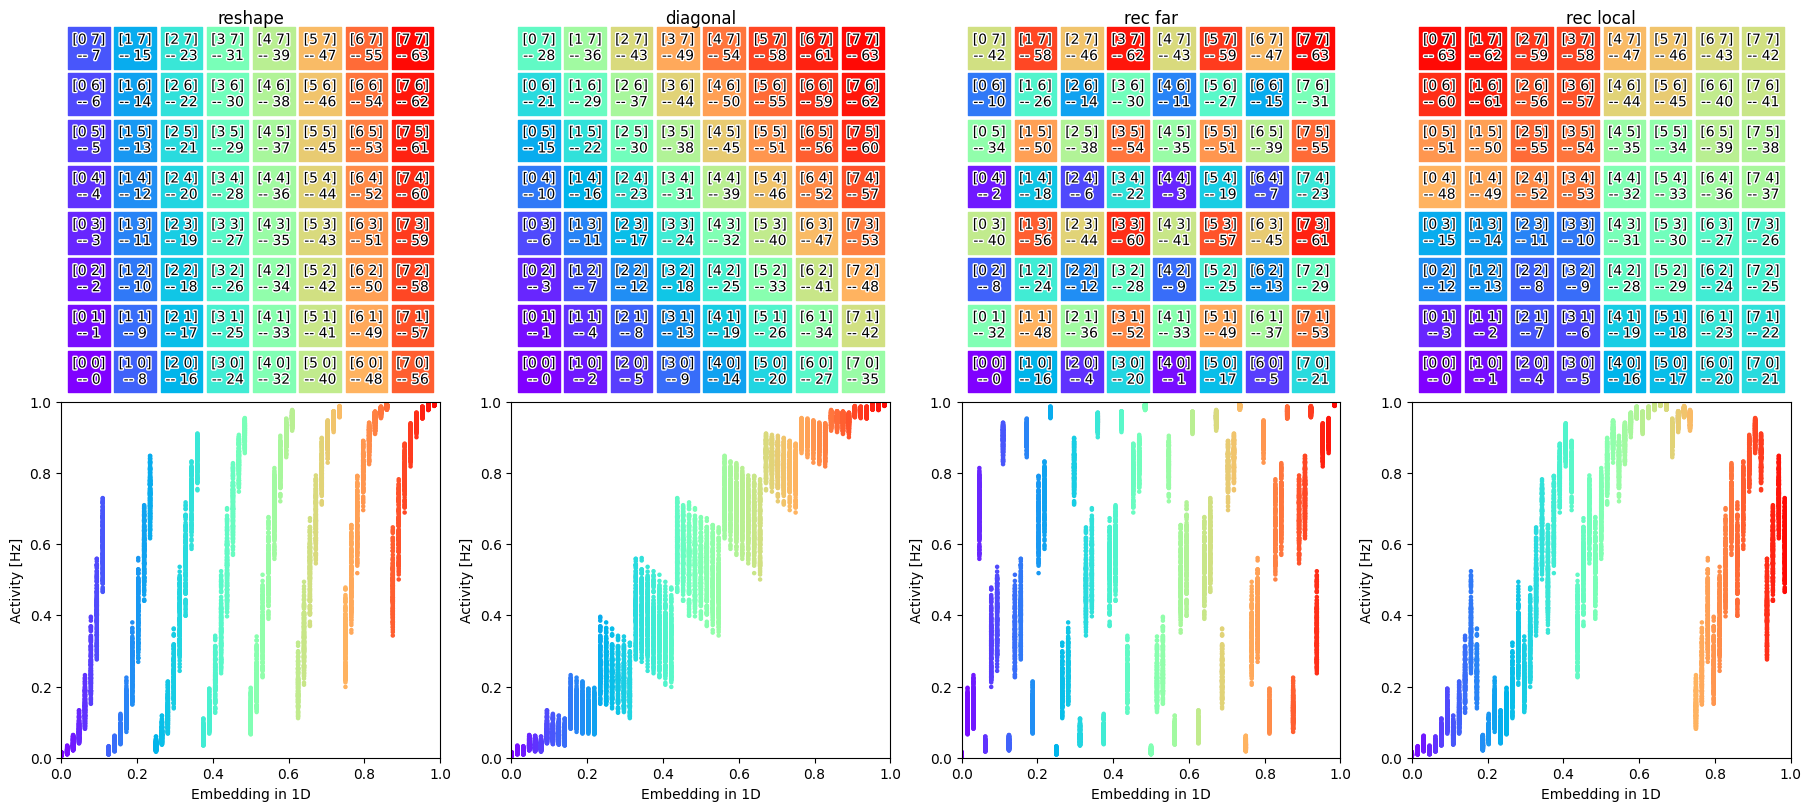

In [13]:
bbox = Box.new_bbox(rnn.F)
F = np.zeros((10_000, 2))  # generate a bunch of uniform data just to test that indices work
F[:, 0] = np.random.default_rng(42).uniform(bbox.xmin, bbox.xmax, len(F))
F[:, 1] = np.random.default_rng(43).uniform(bbox.ymin, bbox.ymax, len(F))

mappings: dict[str, BinMapping] = {
	'reshape': ReshapeMapping(nx=2**3, ny=2**3),
	'diagonal': DiagonalMapping(nx=2**3, ny=2**3),
	'rec far': RecursiveFarMapping(nrec=3),
	'rec local': RecursiveLocalMapping(nrec=3),
}

fig, axes = plt.subplots(ncols=len(mappings), nrows=2, figsize=(4.5*len(mappings), 8), layout='constrained')
cmap = plt.colormaps['rainbow']

for (ax1, ax2), (name, mapping) in zip(axes.T, mappings.items()):
	indices2d = mapping.indices2d(F, bbox)
	indices = mapping.indices(F, bbox)
	# TODO : write these functions so the assertions can work lol
	# assert (mapping.indices2d_to_indices(indices2d) == indices).all()
	# assert (mapping.indices_to_indices2d(indices) == indices2d).all()
	values = mapping(F, bbox)
	_, idx_unique = np.unique(indices, return_index=True)

	ax1.scatter(*indices2d[idx_unique].T, marker='s', s=900, c=cmap(values[idx_unique]), clip_on=False)
	for idx2d, idx1d in zip(indices2d[idx_unique], indices[idx_unique]):
		ax1.annotate(f'{idx2d}\n-- {idx1d}', xy=idx2d, ha='center', va='center',
			path_effects=[pe.withStroke(linewidth=2, foreground='white')])
	ax1.set_title(name)
	ax1.axis('off')
	ax1.set_aspect('equal')

	ax2.scatter(values, fake_activity(F), c=cmap(values), s=5)
	ax2.set_xlim((0, 1))
	ax2.set_ylim((0, 1))
	ax2.set_ylabel('Activity [Hz]')
	ax2.set_xlabel('Embedding in 1D')

## Convergence

We use a 2d colormap so that points close in 2d have a similar color

Plot increasing number of fractal iterations

In [14]:
def cmap2d(F):
	c = np.zeros((len(F), 3))
	c[:, [0, 2]] = Box.new_bbox(F).normalize(F)
	return c

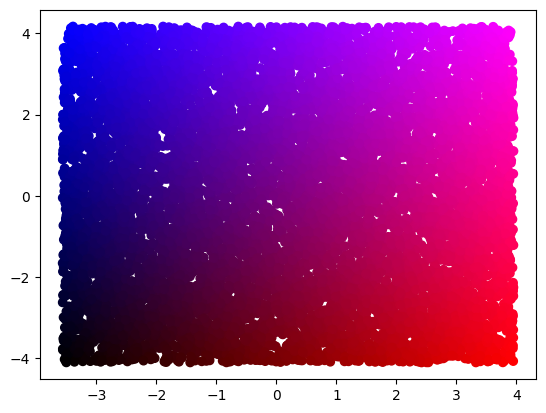

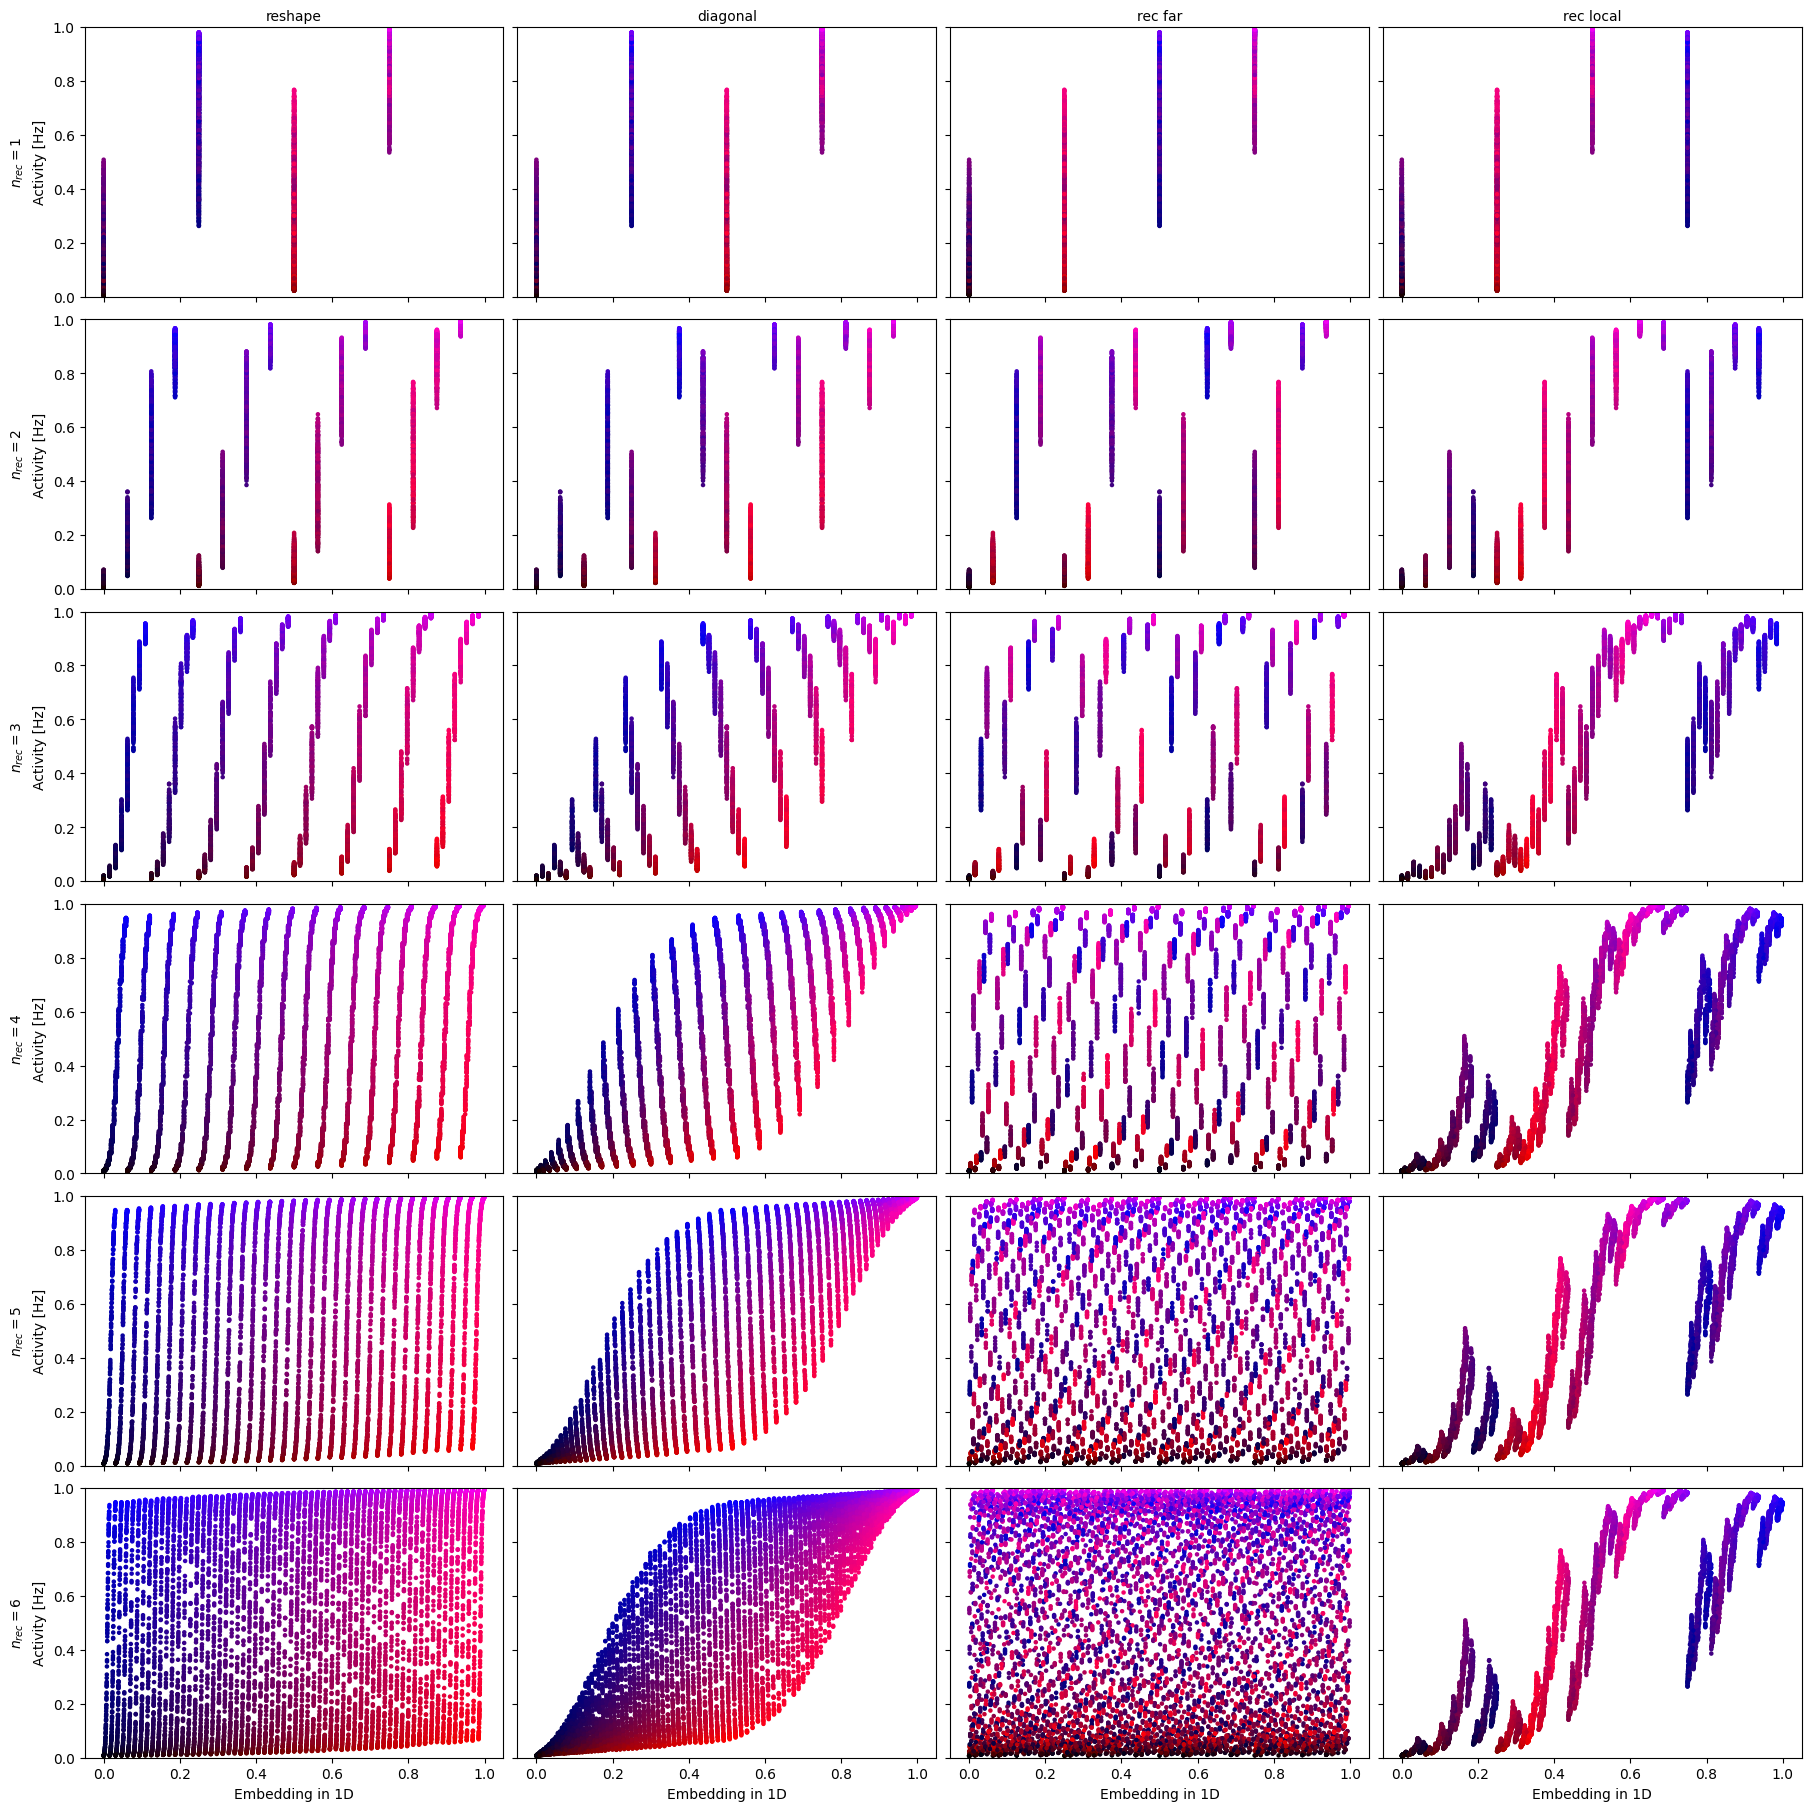

In [23]:
bbox = Box.new_bbox(rnn.F)
F = np.zeros((10_000, 2))  # generate a bunch of uniform data just to test that indices work
F[:, 0] = np.random.default_rng(42).uniform(bbox.xmin, bbox.xmax, len(F))
F[:, 1] = np.random.default_rng(43).uniform(bbox.ymin, bbox.ymax, len(F))

# 2-parameter colormap
c = cmap2d(F)
plt.scatter(*F.T, c=c)
plt.show()

nrecs = [1, 2, 3, 4, 5, 6]

fig, axes = plt.subplots(ncols=4, nrows=len(nrecs), figsize=(4.5*4, 3*len(nrecs)), layout='constrained', sharex=True, sharey=True)
cmap = plt.colormaps['rainbow']

for axs, nrec in zip(axes, nrecs):
	mappings: dict[str, BinMapping] = {
		'reshape': ReshapeMapping(nx=2**nrec, ny=2**nrec),
		'diagonal': DiagonalMapping(nx=2**nrec, ny=2**nrec),
		'rec far': RecursiveFarMapping(nrec=nrec),
		'rec local': RecursiveLocalMapping(nrec=nrec),
	}

	for ax, (name, mapping) in zip(axs, mappings.items()):
		values = mapping(F, bbox)
		# ax.scatter(values, activity, c=cmap(values), s=5)
		ax.scatter(values, fake_activity(F, n=(1,3)), c=c, s=5)
		# ax.set_xlim((0, 1))
		ax.set_ylim((0, 1))
		ax.set_ylabel('Activity [Hz]')
		ax.set_xlabel('Embedding in 1D')
		ax.label_outer()

add_headers(fig, row_headers=[f'$n_{{rec}}={nrec}$' for nrec in nrecs], col_headers=list(mappings.keys()))

## Zooooooom

zoom into fractal, while increasing the number of iterations

try to zoom in while increasing the iteration number

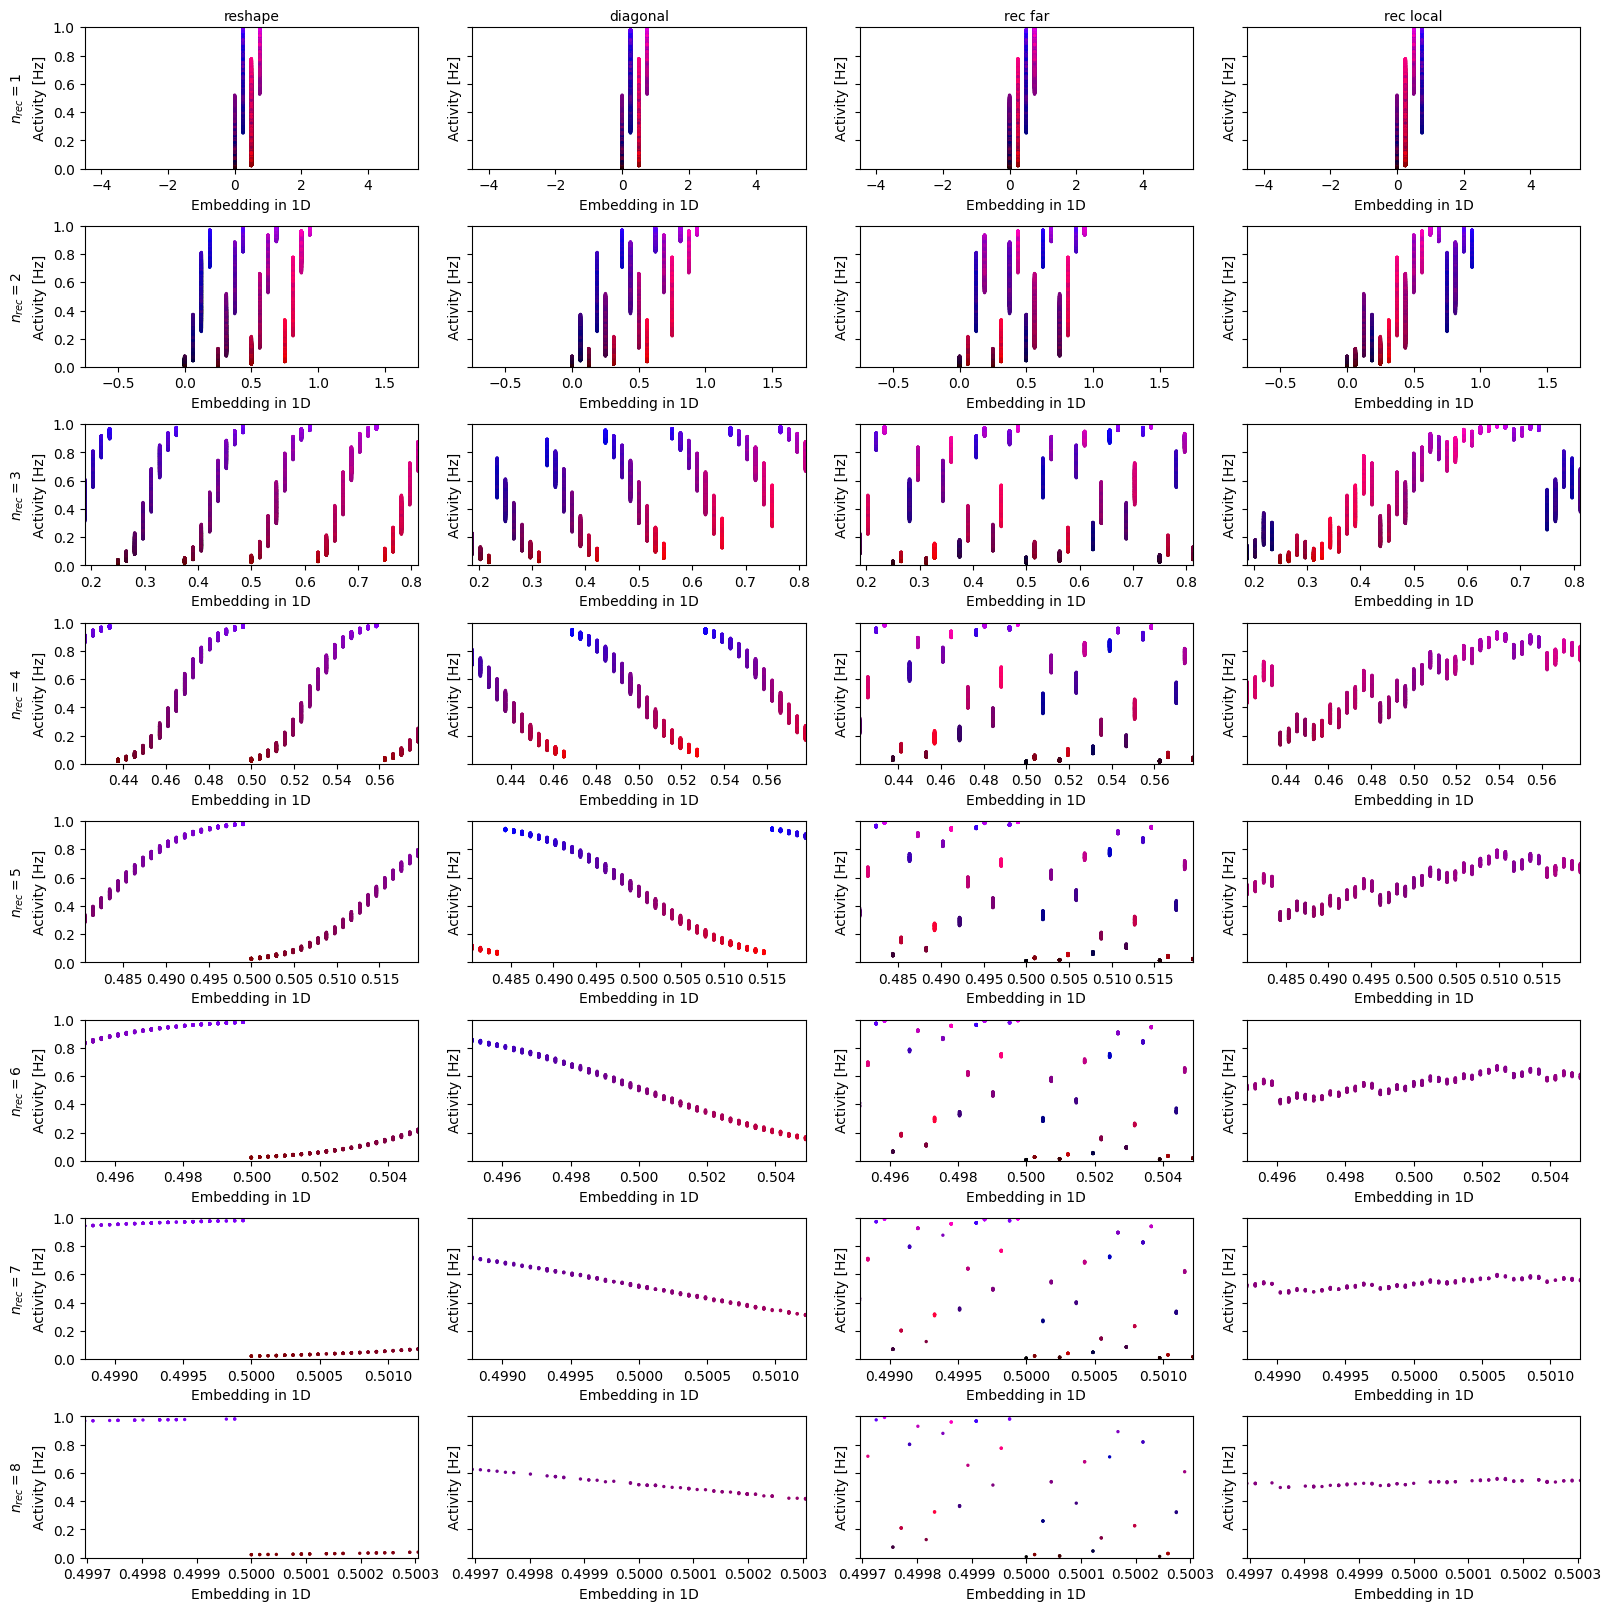

In [26]:
center = 0.5
nrecs = [1, 2, 3, 4, 5, 6, 7, 8]
# nrecs = [1,2,3]

# F = np.zeros((100_000, 2))  # generate a bunch of uniform data just to test that indices work
F = np.zeros((100_000, 2))  # generate a bunch of uniform data just to test that indices work
F[:, 0] = np.random.default_rng(42).uniform(bbox.xmin, bbox.xmax, len(F))
F[:, 1] = np.random.default_rng(43).uniform(bbox.ymin, bbox.ymax, len(F))
activity = fake_activity(F, n=(1,3))
c = cmap2d(F)

fig, axes = plt.subplots(ncols=4, nrows=len(nrecs), figsize=(4*4, 2*len(nrecs)), layout='constrained', sharey=True)

for axs, nrec in zip(axes, nrecs):
	mappings: dict[str, BinMapping] = {
		'reshape': ReshapeMapping(nx=2**nrec, ny=2**nrec),
		'diagonal': DiagonalMapping(nx=2**nrec, ny=2**nrec),
		'rec far': RecursiveFarMapping(nrec=nrec),
		'rec local': RecursiveLocalMapping(nrec=nrec),
	}
	
	for ax, (name, mapping) in zip(axs, mappings.items()):
		values = mapping(F, bbox)
		span = (center-4**(-nrec+1)*5, center+4**(-nrec+1)*5)
		m = (span[0] <= values) & (values <= span[1])
		# ax.axvspan(xmin=center-4**(-nrec), xmax=center+4**(-nrec), color='k', alpha=0.1)
		ax.scatter(values[m], activity[m], c=c[m], s=2)
		ax.set_xlim(span)
		ax.set_ylim((0, 1))
		ax.set_ylabel('Activity [Hz]')
		ax.set_xlabel('Embedding in 1D')

add_headers(fig, row_headers=[f'$n_{{rec}}={nrec}$' for nrec in nrecs], col_headers=list(mappings.keys()))

hypothesis : locality around x AND y

- reshape only has y
- diag is basically a linear mapping with normal vector ~ (1,3)
- recfar is ChAOs
- reclocal has some kind of locality